<a name="top"></a>
# Topic extractive summarization

**Content:**
* [Read dataset](#dat)
* [Markup dataset](#mar)
* [Stopwords, Bigrams and Lemmatize](#sbl)
* [Create the Dictionary and Corpus](#dic)
* [Building the Topic Model](#mod)
* [Find the optimal number of topics](#opt)
* [Dominant topic in each article](#dom)
* [Visualize Topics and Topics-Keywords](#vis)
* [Extractive summarization](#summ)

## Import Packages
[To top](#top)

In [ ]:
import os
import re
import csv
import numpy as np
import pandas as pd
from tqdm import tqdm
from pprint import pprint
from collections import Counter

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel

import warnings, logging
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

from sentence_transformers import SentenceTransformer
from transformers import pipeline
import spacy

# NLTK
import nltk
import nltk.data
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Metrics
from rouge_score import rouge_scorer

<a name="dat"></a>
## Read dataset
[To top](#top)

"BBC News Summary" dataset preloaded from: https://www.kaggle.com/datasets/pariza/bbc-news-summary
<img src="https://storage.googleapis.com/kaggle-datasets-images/24984/31844/1a8eab621fd1b1c55d4474b642d5d25f/dataset-cover.jpg?t=2018-05-04-02-27-09" alt="BBC New" style="width: 500px;"/>

In [2]:
def get_files(root_folders):
    
    ''' Getting file folders and reading text files'''
    
    root_names = os.listdir(os.path.join(root_folders))
    files = []
    pathes = []
    for root_name in root_names:
        filenames = os.listdir(os.path.join(root_folders, root_name))
        for file in filenames:
            text = os.path.join(root_folders, root_name, file)
            result = text.replace(os.sep, '/')
            result = open(result).read()
            # remove the header separated by "\n\n", as this will interfere with the final summation
            files.append(result.replace(re.search(".+\n\n", result)[0], "", 1))
            pathes.append(os.path.join(root_name, file))
    return files, pathes

In [3]:
data_samples, pathes = get_files('News Articles')

tokenizer_pattern = re.compile(r"(?i)\b[a-z]{2,}\b")
data_tokenized = [tokenizer_pattern.findall(text.lower()) for text in data_samples]

In [4]:
data_samples[0], pathes[0]

('Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (ВЈ600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL\'s existing customers for 

<a name="mar"></a>
## Markup dataset
[To top](#top)

In [5]:
# Open and read the article
f = open("News Articles/business/001.txt", "r", encoding="utf8")
to_tokenize = f.read()

# Initialize the HuggingFace summarization pipeline
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")
summarized = summarizer(to_tokenize, min_length=75, max_length=300)

# Print summarized text
print(summarized)

[{'summary_text': ' TimeWarner profits rose 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier . Firm is now one of the biggest investors in Google . But its own internet business, AOL, had has mixed fortunes in the fourth quarter profits were lower than in the preceding three quarters . For the full-year, Time Warner posted a profit of $3.36bn, up 27% from its 2003 performance .'}]


In [6]:
with open('gold_summaries.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['summaries', 'path']) 
    for i in tqdm(range(len(data_samples))):
        csvwriter.writerow([(summarizer(data_samples[i], min_length=75, max_length=300, truncation=True))[0]['summary_text'], pathes[i]])

<a name="sbl"></a>
## Stopwords, Bigrams and Lemmatize
[To top](#top)

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oibuz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\oibuz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
# NLTK Stop words
stop_words = stopwords.words('english')
nltk.download('omw-1.4')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\oibuz\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_tokenized, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_tokenized], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [10]:
wnl = WordNetLemmatizer()

def process_words(texts):
    
    ''' Remove Stopwords, Form Bigrams, Trigrams and Lemmatization'''
    
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        texts_out.append([wnl.lemmatize(token) for token in sent])
    # remove stopwords after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_tokenized)  # processed Text Data!

<a name="dic"></a>
## Create the Dictionary and Corpus
[To top](#top)

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [12]:
corpus[:1]

[[(0, 2),
  (1, 1),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 7),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 2),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 2),
  (32, 2),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 2),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 2),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 3),
  (56, 1),
  (57, 1),
  (58, 2),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 2),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 2),
  (68, 2),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 4),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 1),
  (91, 1)

In [13]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('account', 2),
  ('adjust', 1),
  ('advert', 1),
  ('advertising', 2),
  ('alexander', 1),
  ('already', 1),
  ('amount', 1),
  ('analyst', 1),
  ('aol', 7),
  ('around', 1),
  ('aside', 1),
  ('back', 1),
  ('benefited', 1),
  ('bertelsmann', 1),
  ('better', 1),
  ('biggest', 1),
  ('book', 1),
  ('boosted', 1),
  ('box_office', 1),
  ('broadband', 1),
  ('buoyed', 1),
  ('business', 1),
  ('catwoman', 1),
  ('chairman', 1),
  ('charge', 1),
  ('chief_executive', 1),
  ('close', 1),
  ('company', 2),
  ('concluding', 1),
  ('connection', 1),
  ('contrast', 1),
  ('customer', 2),
  ('deal', 2),
  ('december', 1),
  ('dip', 1),
  ('division', 1),
  ('earlier', 2),
  ('earnings', 1),
  ('effort', 1),
  ('enhancing', 1),
  ('estimate', 1),
  ('europe', 2),
  ('exceeding', 1),
  ('exceptional', 1),
  ('existing', 1),
  ('expectation', 1),
  ('expects', 1),
  ('film', 2),
  ('final', 1),
  ('financial', 1),
  ('firm', 1),
  ('flexibility', 1),
  ('flop', 1),
  ('following', 1),
  ('fort

<a name="mod"></a>
## Building the Topic Model
[To top](#top)

In [14]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.025*"said" + 0.011*"mr" + 0.011*"people" + 0.008*"user" + '
  '0.007*"computer" + 0.006*"new" + 0.006*"software" + 0.005*"system" + '
  '0.005*"service" + 0.005*"online"'),
 (1,
  '0.012*"court" + 0.009*"case" + 0.009*"legal" + 0.008*"lawsuit" + '
  '0.007*"said" + 0.006*"law" + 0.006*"optinrealbig" + 0.006*"apple" + '
  '0.006*"company" + 0.005*"mr"'),
 (2,
  '0.019*"game" + 0.011*"player" + 0.011*"time" + 0.011*"one" + 0.009*"like" + '
  '0.008*"first" + 0.007*"way" + 0.006*"play" + 0.006*"said" + 0.005*"world"'),
 (3,
  '0.016*"game" + 0.009*"win" + 0.008*"team" + 0.007*"year" + 0.007*"said" + '
  '0.007*"match" + 0.007*"last" + 0.007*"second" + 0.006*"first" + '
  '0.006*"title"'),
 (4,
  '0.019*"mobile" + 0.019*"technology" + 0.011*"music" + 0.010*"phone" + '
  '0.010*"digital" + 0.010*"said" + 0.009*"service" + 0.009*"tv" + '
  '0.009*"year" + 0.008*"people"')]


In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.666064740170203

Coherence Score:  0.5031734484493569


<a name="opt"></a>
## Find the optimal number of topics
[To top](#top)

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    
    ''' Compute c_v coherence for various number of topics'''
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics, 
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [18]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=2, limit=20, step=3)

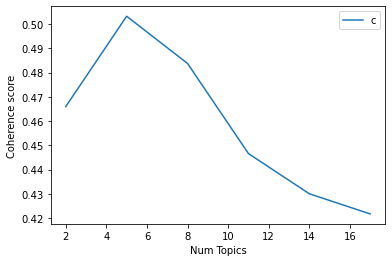

In [19]:
# Show graph
limit=20; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [20]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.466
Num Topics = 5  has Coherence Value of 0.5032
Num Topics = 8  has Coherence Value of 0.4837
Num Topics = 11  has Coherence Value of 0.4466
Num Topics = 14  has Coherence Value of 0.4301
Num Topics = 17  has Coherence Value of 0.4218


In [21]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.025*"said" + 0.011*"mr" + 0.011*"people" + 0.008*"user" + '
  '0.007*"computer" + 0.006*"new" + 0.006*"software" + 0.005*"system" + '
  '0.005*"service" + 0.005*"online"'),
 (1,
  '0.012*"court" + 0.009*"case" + 0.009*"legal" + 0.008*"lawsuit" + '
  '0.007*"said" + 0.006*"law" + 0.006*"optinrealbig" + 0.006*"apple" + '
  '0.006*"company" + 0.005*"mr"'),
 (2,
  '0.019*"game" + 0.011*"player" + 0.011*"time" + 0.011*"one" + 0.009*"like" + '
  '0.008*"first" + 0.007*"way" + 0.006*"play" + 0.006*"said" + 0.005*"world"'),
 (3,
  '0.016*"game" + 0.009*"win" + 0.008*"team" + 0.007*"year" + 0.007*"said" + '
  '0.007*"match" + 0.007*"last" + 0.007*"second" + 0.006*"first" + '
  '0.006*"title"'),
 (4,
  '0.019*"mobile" + 0.019*"technology" + 0.011*"music" + 0.010*"phone" + '
  '0.010*"digital" + 0.010*"said" + 0.009*"service" + 0.009*"tv" + '
  '0.009*"year" + 0.008*"people"')]


<a name="dom"></a>
## Dominant topic in each article
[To top](#top)

In [22]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_samples):
    
    ''' Returns the dominant topic in the document'''
    
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_samples)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0.5052,"said, mr, people, user, computer, new, softwar...",Quarterly profits at US media giant TimeWarner...
1,1,4,0.4498,"mobile, technology, music, phone, digital, sai...",The dollar has hit its highest level against t...
2,2,1,0.7509,"court, case, legal, lawsuit, said, law, optinr...",The owners of embattled Russian oil giant Yuko...
3,3,4,0.4230,"mobile, technology, music, phone, digital, sai...",British Airways has blamed high fuel prices fo...
4,4,0,0.4444,"said, mr, people, user, computer, new, softwar...",Shares in UK drinks and food firm Allied Domec...
5,5,4,0.5559,"mobile, technology, music, phone, digital, sai...",Japan's economy teetered on the brink of a tec...
6,6,4,0.6245,"mobile, technology, music, phone, digital, sai...",The US created fewer jobs than expected in Jan...
7,7,0,0.4956,"said, mr, people, user, computer, new, softwar...","India, which attends the G7 meeting of seven l..."
8,8,0,0.7313,"said, mr, people, user, computer, new, softwar...",Ethiopia produced 14.27 million tonnes of crop...
9,9,0,0.6123,"said, mr, people, user, computer, new, softwar...",A US government claim accusing the country's b...


In [23]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_dominant_topic.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Document_No', 'Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Document_No,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,1941,0,0.9911,"said, mr, people, user, computer, new, software, system, service, online",By early 2005 the net could have two new domain names.\n\nThe .post and .travel net domains have...
1,229,1,0.8234,"court, case, legal, lawsuit, said, law, optinrealbig, apple, company, mr",Russian oil company Yukos has dropped the threat of legal action against five banks it had accus...
2,706,2,0.8248,"game, player, time, one, like, first, way, play, said, world","The permanent replacement for late DJ John Peel's BBC Radio 1 show goes on air on Tuesday, with ..."
3,593,3,0.9782,"game, win, team, year, said, match, last, second, first, title","Leonardo DiCaprio, Jamie Foxx and Hilary Swank are among those due to attend this year's Oscar n..."
4,414,4,0.8613,"mobile, technology, music, phone, digital, said, service, tv, year, people","UK house prices dipped slightly in November, the Office of the Deputy Prime Minister (ODPM) has ..."


<a name="vis"></a>
## Visualize Topics and Topics-Keywords
[To top](#top)

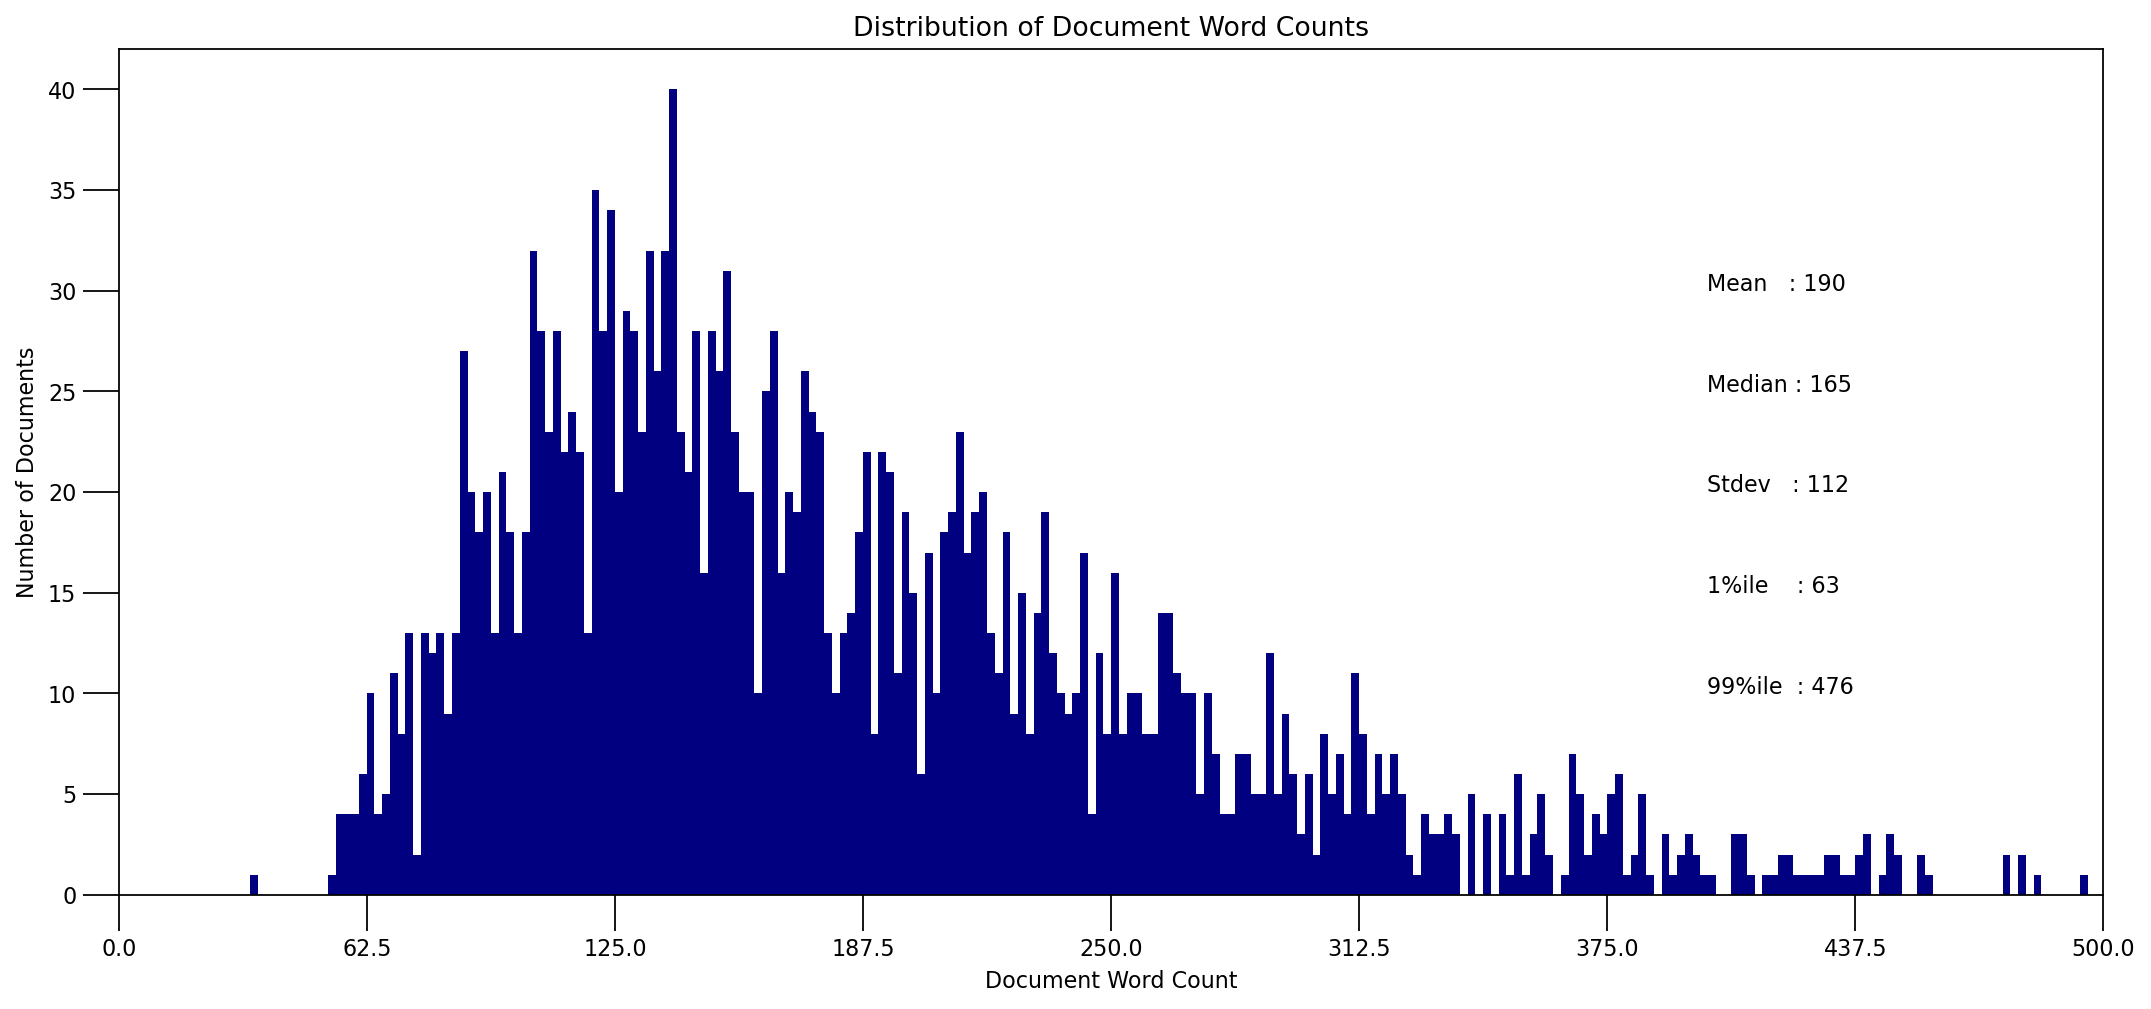

In [24]:
doc_lens = [len(d) for d in data_ready]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(400, 30, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(400,  25, "Median : " + str(round(np.median(doc_lens))))
plt.text(400,  20, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(400,  15, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(400,  10, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 500), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,500,9))
plt.title('Distribution of Document Word Counts')
plt.show()

In [25]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = {}
for i, topic in topics:
    if i  not in out:
        out[i] = {'word': [], 'importance': [], 'word_count': []}
    for word, weight in topic:
        out[i]["word"].append(word)
        out[i]["importance"].append(weight)
        out[i]["word_count"].append(counter[word])

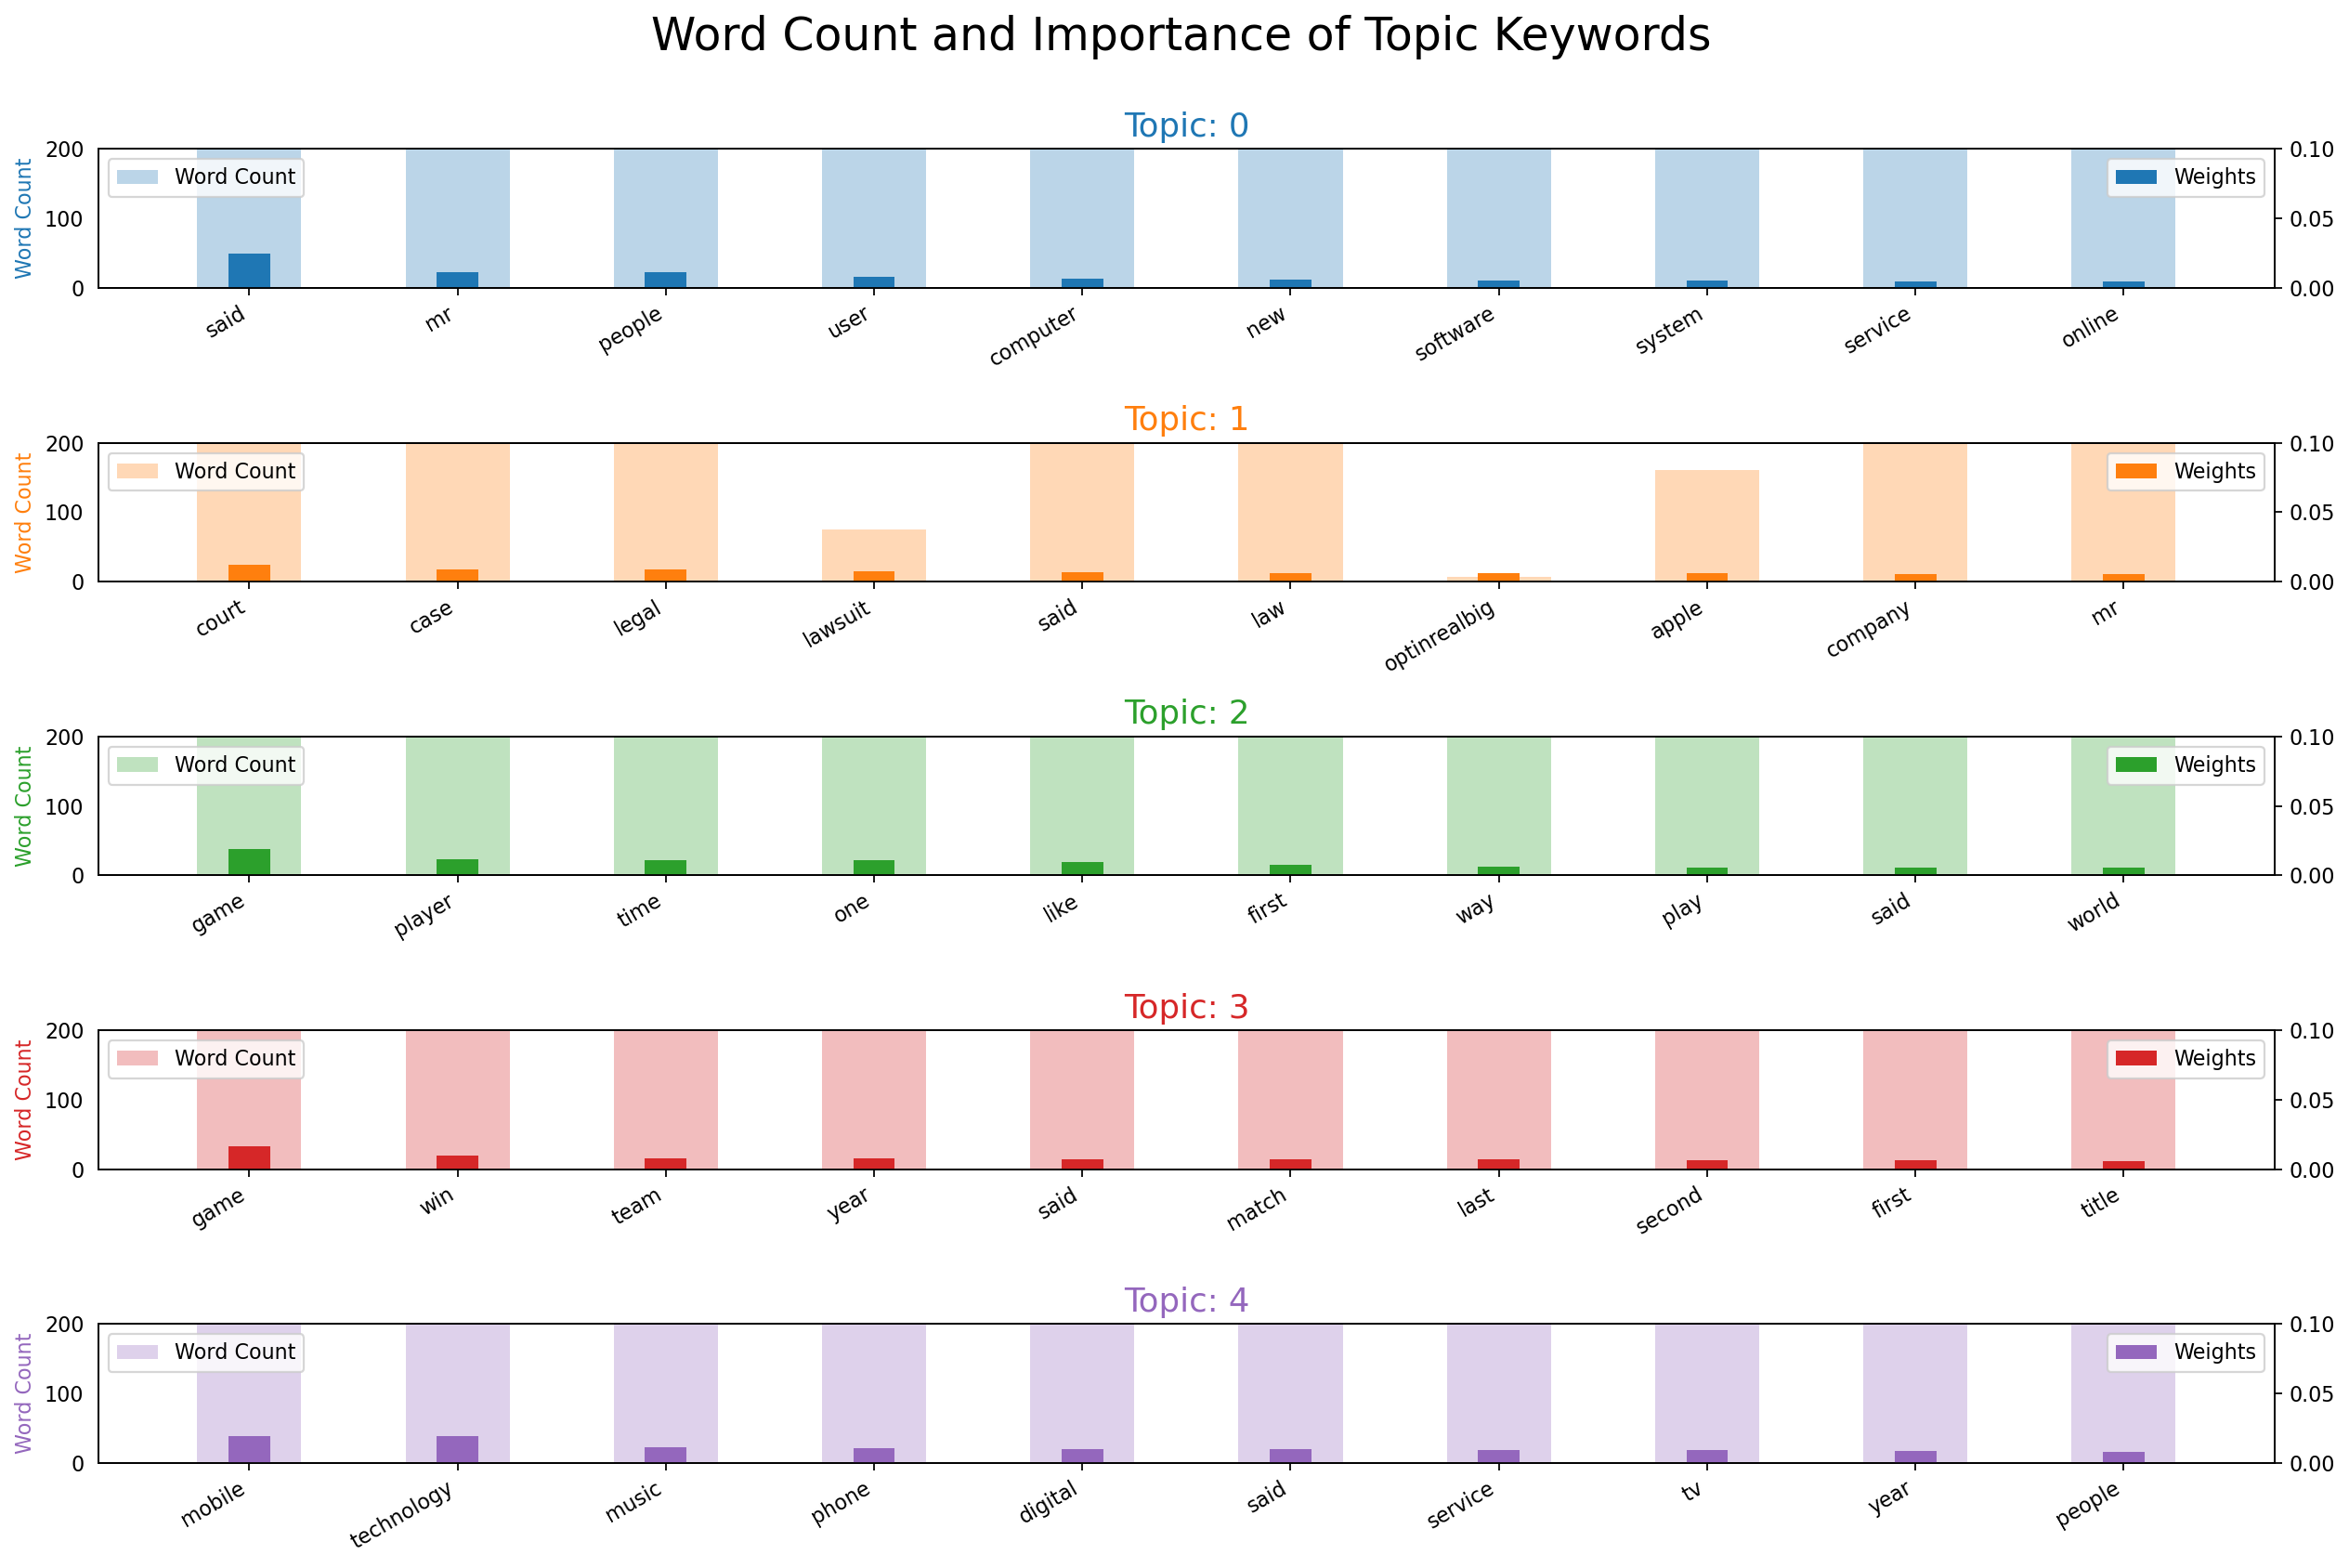

In [26]:
# Plot Word Count and Weights of Topic Keywords

fig, axes = plt.subplots(5, 1, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=out[i], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=out[i], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.10); ax.set_ylim(0, 200)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [27]:
# Sentence Coloring of N Sentences

def sentences_chart(lda_model=lda_model, corpus=corpus, start=0, end=13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]

            ax.text(0.01, 0.5, "Doc " + str(i-1 + start) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-1), 
                 fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

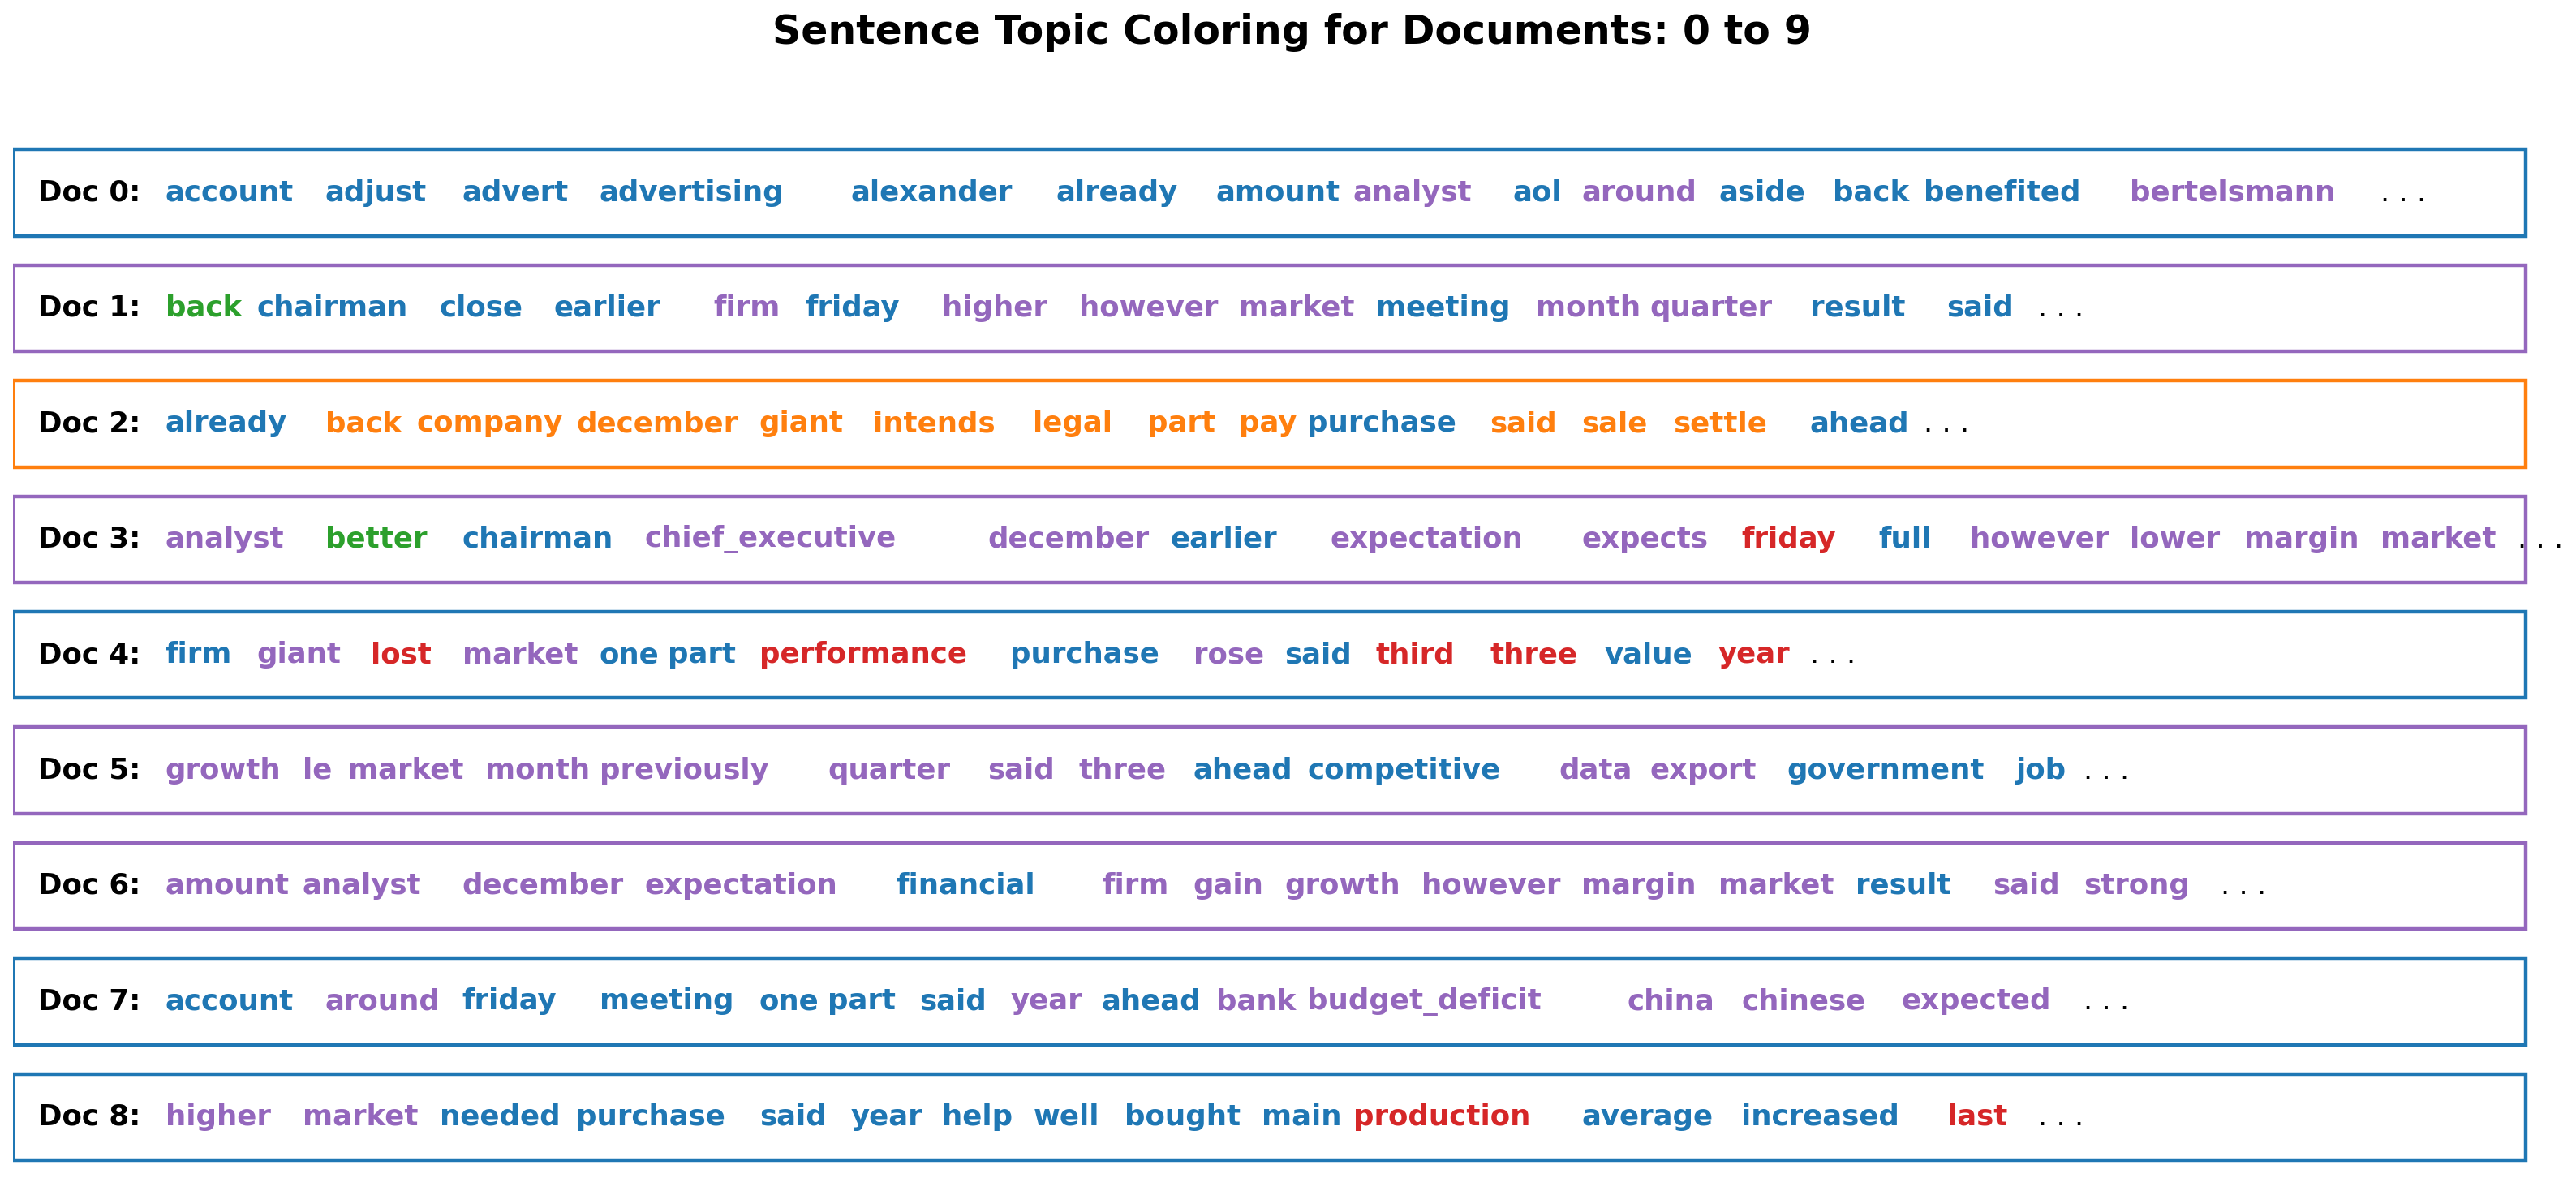

In [28]:
sentences_chart(start=0, end=10)

In [29]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.088681 -0.074725       1        1  40.003206
2     -0.036124 -0.230050       2        1  23.174663
3     -0.192090 -0.036160       3        1  17.841141
4      0.289098  0.096572       4        1  13.643545
1     -0.149565  0.244364       5        1   5.337445, topic_info=            Term         Freq        Total Category  logprob  loglift
2289        game  3064.000000  3064.000000  Default  30.0000  30.0000
1424      mobile  1119.000000  1119.000000  Default  29.0000  29.0000
1270  technology  1184.000000  1184.000000  Default  28.0000  28.0000
233           mr  2084.000000  2084.000000  Default  27.0000  27.0000
884       player  1414.000000  1414.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
233           mr   120.841524  2084.300508   Topic5  -5.2285   0.0827
125         said   147.414256  5996.412547   Topic5  -5.0297  -0.7752
312       former    73.386788   290.305264   Topic5  -5.7272   1.5552
1658   statement    65.663681   186.386339   Topic5  -5.8384   1.8871
33      december    63.888549   181.976843   Topic5  -5.8658   1.8837

[331 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3228      1  0.998476     access
609       1  0.382150  according
609       3  0.003710  according
609       4  0.612182  according
8370      3  0.991813      actor
...     ...       ...        ...
155       3  0.294254       year
155       4  0.268599       year
155       5  0.016755       year
5921      2  0.152957   year_old
5921      3  0.846143   year_old

[482 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 5, 2])

<a name="summ"></a>
## Extractive summarization
[To top](#top)

In [30]:
gold_summarie = pd.read_csv('gold_summaries.csv')
gold_summarie = gold_summarie.sort_values('path').reset_index(drop = True)
gold_summarie.head(10)

,summaries,path
0,TimeWarner's fourth quarter profits rose 76% to $1.13bn (£600m) for the three months to Decembe...,business/001.txt
1,Alan Greenspan highlighted the US government's willingness to curb spending and rising househol...,business/002.txt
2,State-owned Rosneft bought the Yugansk unit for $9.3bn in a sale forced by Russia to part settl...,business/003.txt
3,British Airways blames high fuel prices for 40% drop in profits . BA made pre-tax profit of £75...,business/004.txt
4,"Allied Domecq shares in London rose 4% by 1200 GMT, while Pernod shares in Paris slipped 1.2% ....",business/005.txt
5,Japan's economy teetered on the brink of a technical recession in the three months to September...,business/006.txt
6,"US firms added only 146,000 jobs in January, down from 190,000 expected . Jobless rate falls to...",business/007.txt
7,G7 meeting takes place in London on Friday and Saturday . India is expected to face pressure fr...,business/008.txt
8,"Ethiopia produced 14.27 million tonnes of crops in 2004, 24% more than in 2003 . Good rains, in...",business/009.txt
9,Court of Appeals for the District of Columbia ruled that the case could not be brought under fe...,business/010.txt


In [31]:
spacy_model = spacy.load("en_core_web_md")

In [32]:
def text_to_sent_list(text, 
                      nlp = spacy_model, 
                      embedder = SentenceTransformer('distilbert-base-nli-mean-tokens'),
                      min_len=2):
  
    ''' Returns cleaned article sentences and BERT sentence embeddings'''
    
    #convert to list of sentences
    text = nlp(text)
    sents = list(text.sents)
    #remove short sentences by threshhold                                                                                                
    sents_clean = [sentence.text for sentence in sents if len(sentence)> min_len]
    #remove entries with empty list
    sents_clean = [sentence for sentence in sents_clean if len(sentence)!=0]
    #embed sentences (deafult uses BERT SentenceTransformer)
    sents_embedding= np.array(embedder.encode(sents_clean, convert_to_tensor=True))
    
    return sents_clean, sents_embedding

In [33]:
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oibuz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [34]:
def calc_rouge_scores(pred_summaries, gold_summaries, 
                                 keys=['rouge1', 'rougeL'], use_stemmer=True):
    
    ''' Returns rouge scores between the gold summary and the predicted summary'''
    
    #Calculate rouge scores
    scorer = rouge_scorer.RougeScorer(keys, use_stemmer= use_stemmer)
    n = len(pred_summaries)
    scores = [scorer.score(pred_summaries[j], gold_summaries[j]) for 
              j in range(n)]
              
    #create dict
    dict_scores={}                                                            
    for key in keys:
        dict_scores.update({key: {}})
        
    #populate dict    
    for key in keys:
        
        precision_list = [scores[j][key][0] for j in range(len(scores))]
        recall_list = [scores[j][key][1] for j in range(len(scores))]
        f1_list = [scores[j][key][2] for j in range(len(scores))]

        precision = np.mean(precision_list)
        recall = np.mean(recall_list)
        f1 = np.mean(f1_list)
        
        dict_results = {'recall': recall, 'precision': precision, 'f1': f1}
        
        dict_scores[key] = dict_results
        
    return dict_scores

In [35]:
WORD = re.compile(r"\w+")

def get_cosine(vec1, vec2):
    
    ''' Returns the similarity value of two vectors'''
    
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = np.sqrt(sum1) * np.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)

summ_metrics_df = pd.DataFrame()

for num_text in tqdm(range(len(df_dominant_topic))):
    vector1 = text_to_vector(df_dominant_topic['Keywords'][num_text])

    cos_ind = []
    for i in range(len(sent_detector.tokenize(df_dominant_topic['Text'][num_text]))):
        vector2 = text_to_vector(' '.join(process_words(sent_detector.tokenize(df_dominant_topic['Text'][num_text]))[i]))
        cosine = get_cosine(vector1, vector2)
    #     print("Cosine:", round(cosine,3))
        cos_ind.append(cosine)

    cos_sort = np.argsort(cos_ind)[-3::]

    pred_summarie = []
    for j,_ in enumerate(np.sort(cos_sort)):
        pred_summarie.append(sent_detector.tokenize(df_dominant_topic['Text'][num_text])[j])

    
    if len(text_to_sent_list(gold_summarie['summaries'][num_text])[0]) >= len(pred_summarie):
        summ_metrics_df = summ_metrics_df.append(pd.Series([pred_summarie,
                                                      calc_rouge_scores(pred_summarie, text_to_sent_list(gold_summarie['summaries'][num_text])[0])['rouge1']['f1'],
                                                      calc_rouge_scores(pred_summarie, text_to_sent_list(gold_summarie['summaries'][num_text])[0])['rouge1']['recall'],
                                                      calc_rouge_scores(pred_summarie, text_to_sent_list(gold_summarie['summaries'][num_text])[0])['rouge1']['precision'],
                                                      calc_rouge_scores(pred_summarie, text_to_sent_list(gold_summarie['summaries'][num_text])[0])['rougeL']['f1'],
                                                      calc_rouge_scores(pred_summarie, text_to_sent_list(gold_summarie['summaries'][num_text])[0])['rougeL']['recall'],
                                                      calc_rouge_scores(pred_summarie, text_to_sent_list(gold_summarie['summaries'][num_text])[0])['rougeL']['precision']]), ignore_index=True)
    
    else:
        len_summ = len(text_to_sent_list(gold_summarie['summaries'][num_text])[0])
        
        cos_sort = np.argsort(cos_ind)[-len_summ::]

        pred_summarie = []
        for j,_ in enumerate(np.sort(cos_sort)):
            pred_summarie.append(sent_detector.tokenize(df_dominant_topic['Text'][num_text])[j])
        
        summ_metrics_df = summ_metrics_df.append(pd.Series([pred_summarie,
                                                      calc_rouge_scores(pred_summarie[:len_summ], text_to_sent_list(gold_summarie['summaries'][num_text])[0])['rouge1']['f1'],
                                                      calc_rouge_scores(pred_summarie[:len_summ], text_to_sent_list(gold_summarie['summaries'][num_text])[0])['rouge1']['recall'],
                                                      calc_rouge_scores(pred_summarie[:len_summ], text_to_sent_list(gold_summarie['summaries'][num_text])[0])['rouge1']['precision'],
                                                      calc_rouge_scores(pred_summarie[:len_summ], text_to_sent_list(gold_summarie['summaries'][num_text])[0])['rougeL']['f1'],
                                                      calc_rouge_scores(pred_summarie[:len_summ], text_to_sent_list(gold_summarie['summaries'][num_text])[0])['rougeL']['recall'],
                                                      calc_rouge_scores(pred_summarie[:len_summ], text_to_sent_list(gold_summarie['summaries'][num_text])[0])['rougeL']['precision']]), ignore_index=True)

summ_metrics_df = pd.concat([summ_metrics_df, gold_summarie], axis=1)
summ_metrics_df.columns = ['pred_summaries', 'r1_f1', 'r1_recall', 'r1_precision', 'rL_f1', 'rL_recall', 'rL_precision', 'summaries', 'path']
summ_metrics_df.head(10)

100%|██████████████████████████████████████████████████████████████████████████████| 2225/2225 [32:34<00:00,  1.14it/s]


,pred_summaries,r1_f1,r1_recall,r1_precision,rL_f1,rL_recall,rL_precision,summaries,path
0,[Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (ВЈ600m) for the three mon...,0.453654,0.385266,0.603175,0.438503,0.370773,0.587302,TimeWarner's fourth quarter profits rose 76% to $1.13bn (£600m) for the three months to Decembe...,business/001.txt
1,[The dollar has hit its highest level against the euro in almost three months after the Federal ...,0.155450,0.143588,0.172179,0.111288,0.102235,0.124675,Alan Greenspan highlighted the US government's willingness to curb spending and rising househol...,business/002.txt
2,[The owners of embattled Russian oil giant Yukos are to ask the buyer of its former production u...,0.158657,0.147436,0.175214,0.116599,0.108462,0.129060,State-owned Rosneft bought the Yugansk unit for $9.3bn in a sale forced by Russia to part settl...,business/003.txt
3,"[British Airways has blamed high fuel prices for a 40% drop in profits., Reporting its results f...",0.580430,0.498101,0.716931,0.564557,0.484212,0.698413,British Airways blames high fuel prices for 40% drop in profits . BA made pre-tax profit of £75...,business/004.txt
4,[Shares in UK drinks and food firm Allied Domecq have risen on speculation that it could be the ...,0.170190,0.135802,0.230159,0.140560,0.111111,0.193122,"Allied Domecq shares in London rose 4% by 1200 GMT, while Pernod shares in Paris slipped 1.2% ....",business/005.txt
5,[Japan's economy teetered on the brink of a technical recession in the three months to September...,0.861504,0.767200,1.000000,0.861504,0.767200,1.000000,Japan's economy teetered on the brink of a technical recession in the three months to September...,business/006.txt
6,"[The US created fewer jobs than expected in January, but a fall in jobseekers pushed the unemplo...",0.157088,0.134921,0.194444,0.139994,0.121587,0.170635,"US firms added only 146,000 jobs in January, down from 190,000 expected . Jobless rate falls to...",business/007.txt
7,"[India, which attends the G7 meeting of seven leading industrialised nations on Friday, is unlik...",0.142544,0.114315,0.200000,0.142544,0.114315,0.200000,G7 meeting takes place in London on Friday and Saturday . India is expected to face pressure fr...,business/008.txt
8,"[Ethiopia produced 14.27 million tonnes of crops in 2004, 24% higher than in 2003 and 21% more t...",0.295649,0.227969,0.422222,0.246309,0.188697,0.355556,"Ethiopia produced 14.27 million tonnes of crops in 2004, 24% more than in 2003 . Good rains, in...",business/009.txt
9,[A US government claim accusing the country's biggest tobacco companies of covering up the effec...,0.290464,0.241010,0.384127,0.200291,0.167461,0.262434,Court of Appeals for the District of Columbia ruled that the case could not be brought under fe...,business/010.txt


In [36]:
print('   Metrics | Rouge1 | RougeL')
print('-------------------------------')
print(f"        F1 |  {round(summ_metrics_df['r1_f1'].mean(), 2)}  |  {round(summ_metrics_df['rL_f1'].mean(), 2)}")
print('-------------------------------')
print(f"    Recall |  {round(summ_metrics_df['r1_recall'].mean(), 2)}  |  {round(summ_metrics_df['rL_recall'].mean(),2)}")
print('-------------------------------')
print(f" Precision |  {round(summ_metrics_df['r1_precision'].mean(), 2)}  |  {round(summ_metrics_df['rL_precision'].mean(),2)}")

   Metrics | Rouge1 | RougeL
-------------------------------
        F1 |  0.33  |  0.31
-------------------------------
    Recall |  0.31  |  0.28
-------------------------------
 Precision |  0.39  |  0.35
